In [18]:
import sys
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [14]:
# In case your sys.path does not contain the base repo, go there.
print(sys.path)
%cd '/Users/axelsirota/repos/ml-solr-course'

['/Users/axelsirota/repos/ml-solr-course/2-ranking/lab-bonus/solutions', '/Users/axelsirota/.pyenv/versions/3.7.3/lib/python37.zip', '/Users/axelsirota/.pyenv/versions/3.7.3/lib/python3.7', '/Users/axelsirota/.pyenv/versions/3.7.3/lib/python3.7/lib-dynload', '', '/Users/axelsirota/repos/ml-solr-course/.venv/lib/python3.7/site-packages', '/Users/axelsirota/repos/ml-solr-course/.venv/lib/python3.7/site-packages/IPython/extensions', '/Users/axelsirota/.ipython']
/Users/axelsirota/repos/ml-solr-course


The idea behind RankNet is to model the **joint probability** that `document i` comes before `document j` as the following:

$P_{ij} = 1$ if $s_i > s_j$
$P_{ij} = 0.5$ if $s_i = s_j$
$P_{ij} = 0$ if $s_i < s_j$

So for *every pair of inputs* we will calculate both outputs, substract them, pass a logistic function to model the probability:

<img src="files/ranknet.png">

In [15]:
# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()

    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output

    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))

In [5]:
nb_query = 20
query = np.array([i+1 for i in range(nb_query) for x in range(int(np.ceil(np.abs(np.random.normal(0,scale=15))+2)))])
doc_features = np.random.random((len(query), 10))
doc_scores = np.random.randint(5, size=len(query)).astype(np.float32)


In [6]:
query

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14

In [7]:
print(doc_scores)
doc_features

[4. 3. 3. 4. 3. 2. 4. 2. 2. 4. 0. 3. 1. 1. 0. 2. 1. 2. 0. 1. 0. 2. 3. 3.
 3. 1. 2. 1. 3. 2. 1. 1. 2. 0. 0. 0. 3. 2. 2. 3. 3. 3. 4. 0. 0. 4. 4. 0.
 4. 1. 3. 4. 4. 2. 0. 2. 2. 1. 0. 3. 1. 0. 0. 4. 2. 1. 1. 0. 3. 0. 4. 0.
 2. 2. 1. 4. 2. 1. 0. 1. 3. 3. 1. 2. 2. 4. 1. 1. 4. 2. 1. 4. 2. 0. 2. 0.
 0. 3. 3. 1. 3. 2. 0. 0. 4. 0. 2. 3. 1. 0. 3. 3. 2. 4. 3. 0. 3. 0. 4. 3.
 1. 0. 1. 4. 4. 0. 3. 0. 0. 2. 2. 2. 4. 2. 0. 0. 0. 3. 0. 0. 0. 4. 2. 4.
 3. 0. 2. 2. 0. 2. 1. 2. 3. 0. 4. 2. 4. 2. 2. 4. 2. 2. 0. 4. 3. 2. 1. 0.
 2. 0. 0. 4. 0. 3. 3. 1. 2. 3. 3. 1. 4. 1. 0. 4. 1. 1. 0. 1. 1. 2. 1. 0.
 0. 3. 2. 2. 1. 1. 1. 4. 3. 0. 0. 2. 0. 2. 0. 0. 3. 0. 4. 1. 1. 0. 4. 2.
 2. 0. 3. 0. 4. 0. 0. 4. 0. 2. 1. 4. 2. 3. 3. 1. 1. 0. 0. 3. 3. 1. 2. 0.
 3. 3. 3. 0. 0. 2. 1. 4. 3. 4. 4. 4. 2. 1. 2. 1. 1. 4. 1. 2. 0. 4. 1. 3.
 2. 0. 4. 2. 0. 1. 1. 4. 2. 0. 2. 4. 4. 1. 4. 2. 2. 0. 0. 0. 2. 3. 1. 2.
 4. 3. 3. 2. 3. 3. 0. 0. 4. 4. 4. 4. 4. 1. 4. 0. 0. 0. 3. 4. 4. 1. 1. 1.
 4. 4. 3. 2. 1. 2. 2. 1. 4. 3. 4. 2. 0. 0. 4. 3. 3.

array([[0.87644563, 0.66895054, 0.60619895, ..., 0.04043289, 0.3096737 ,
        0.810136  ],
       [0.70050241, 0.51510371, 0.38198662, ..., 0.48284196, 0.82637603,
        0.87618028],
       [0.8800547 , 0.83072176, 0.73522337, ..., 0.24368589, 0.10349975,
        0.5102918 ],
       ...,
       [0.00654856, 0.77752541, 0.56195898, ..., 0.69579795, 0.33418575,
        0.11397216],
       [0.4361493 , 0.25468854, 0.0286591 , ..., 0.71249739, 0.52234718,
        0.64695395],
       [0.33737423, 0.149602  , 0.46826469, ..., 0.75199457, 0.34655794,
        0.90934746]])

In [8]:
# put data into pairs
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []
for q in np.unique(query):
    query_idx = np.where(query == q)[0]
    for pair_idx in combinations(query_idx, 2):
        pair_query_id.append(q)

        pair_id.append(pair_idx)
        i = pair_idx[0]
        j = pair_idx[1]
        xi.append(doc_features[i])
        xj.append(doc_features[j])

        if doc_scores[i] == doc_scores[j]:
            _pij = 0.5
        elif doc_scores[i] > doc_scores[j]:
            _pij = 1
        else:
            _pij = 0
        pij.append(_pij)

xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_query_id = np.array(pair_query_id)

In [9]:
xi_train, xi_test, xj_train, xj_test, pij_train, pij_test, pair_id_train, pair_id_test = train_test_split(
    xi, xj, pij, pair_id, test_size=0.2, stratify=pair_query_id)

In [10]:
# train model using compile and fit
ranknet = RankNet()
ranknet.compile(optimizer='adam', loss='binary_crossentropy')
history = ranknet.fit([xi_train, xj_train], pij_train, epochs=50, batch_size=1, validation_data=([xi_test, xj_test], pij_test))

2021-07-24 23:16:27.952161: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
3850/3850 [==============================] - 3s 701us/step - loss: 0.6845 - val_loss: 0.6715
Epoch 2/50
3850/3850 [==============================] - 3s 679us/step - loss: 0.6574 - val_loss: 0.6551
Epoch 3/50
3850/3850 [==============================] - 3s 666us/step - loss: 0.6363 - val_loss: 0.6358
Epoch 4/50
3850/3850 [==============================] - 3s 791us/step - loss: 0.6185 - val_loss: 0.6269
Epoch 5/50
3850/3850 [==============================] - 3s 670us/step - loss: 0.6082 - val_loss: 0.6112
Epoch 6/50
3850/3850 [==============================] - 3s 688us/step - loss: 0.5954 - val_loss: 0.5999
Epoch 7/50
3850/3850 [==============================] - 3s 652us/step - loss: 0.5842 - val_loss: 0.5919
Epoch 8/50
3850/3850 [==============================] - 3s 657us/step - loss: 0.5709 - val_loss: 0.5779
Epoch 9/50
3850/3850 [==============================] - 3s 651us/step - loss: 0.5576 - val_loss: 0.5694
Epoch 10/50
3850/3850 [==============================] - 3s 654u

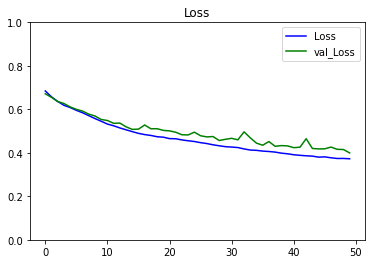

In [11]:
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [36]:
new_doci = [np.random.random(10), np.random.random(10)]
new_docj = [np.random.random(10), np.random.random(10)]
inputs = tf.constant(np.array([new_doci, new_docj]))
ranknet(inputs)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.5832063 ],
       [0.23671651]], dtype=float32)>